# Train a detection model on COCO dataset
<p3> Set location to the dataset path below <p3>

In [2]:
location = "Path/To/Dataset"

In [5]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] =pixel_values[0].unsqueeze(0)
    batch['labels'] = labels
    return batch

In [3]:
import torchvision
import os
from datasets.coco import CocoDetection
from datasets.coco import make_coco_transforms


train_dataset = CocoDetection(img_folder=(location + '/train'), ann_file=location + '/train/_annotations.coco.json', transforms=make_coco_transforms('train'), return_masks=False)
val_dataset = CocoDetection(img_folder=(location + '/valid'), ann_file=location + '/valid/_annotations.coco.json', transforms=make_coco_transforms('val'), return_masks=False)

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 4149
Number of validation examples: 1062


Image n°1874


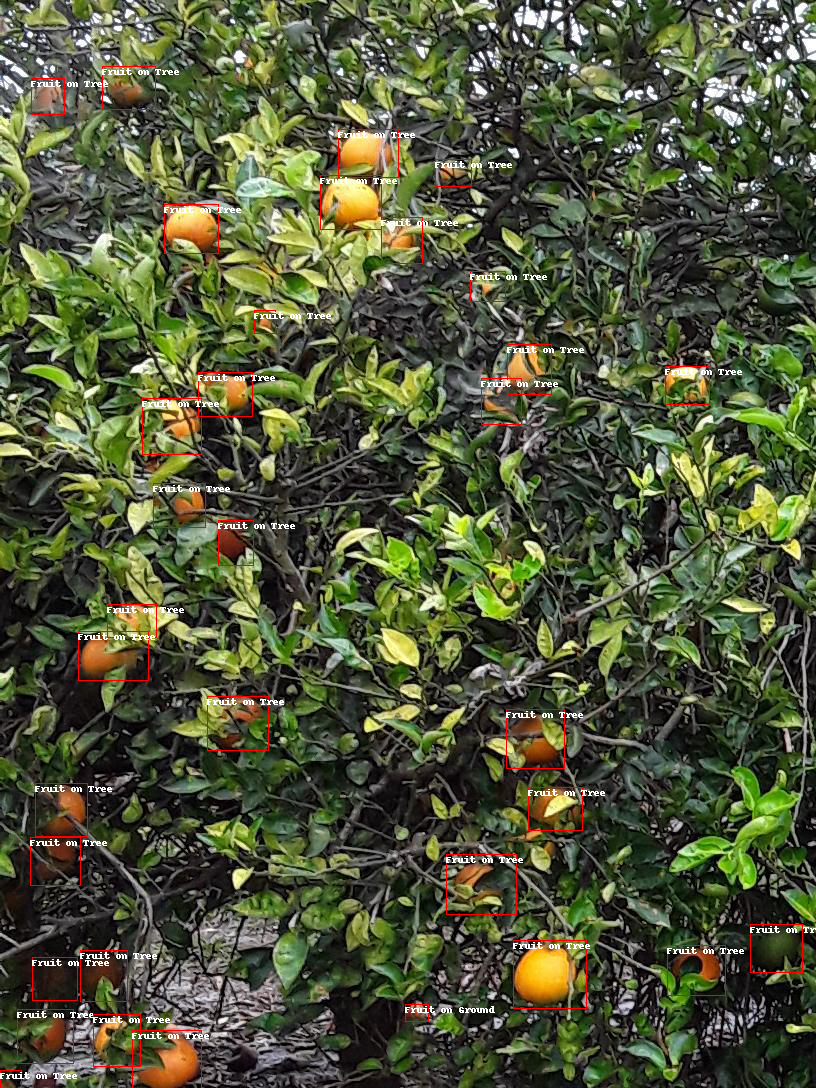

In [10]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(location + '/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [12]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


#we wrap our model around pytorch lightning for training
class DETR(pl.LightningModule):

    def __init__(self, lr, weight_decay, weights=None):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                         num_queries=100,
                                                         backbone='resnet50',
                                                         auxiliary_loss=False,
                                                         num_labels=len(id2label),
                                                         ignore_mismatched_sizes=True)
        if weights is not None:
            self.model.load_state_dict(torch.load(weights))
        self.lr = lr
        self.weight_decay = weight_decay
        self.save_hyperparameters()

    def forward(self, pixel_values):
        outputs = self.model(pixel_values=pixel_values)

        return outputs
     
    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("train/loss", loss) 
        for k,v in loss_dict.items():
            self.log("train/" + k, v.item()) 

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss) 
        for k,v in loss_dict.items():
            self.log("validation/" + k, v.item())

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [14]:
model = DETR(lr=2.5e-5, weight_decay=1e-4, weights="CitDETR.pth")

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([4, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Login to wandb for logging

In [ ]:
import wandb
wandb.login()

In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

wandb_logger = WandbLogger(project='CitDet', log_model=True)

checkpoint_callback = ModelCheckpoint(monitor="validation/loss", mode="min")

In [15]:
from pytorch_lightning import Trainer

trainer = Trainer(gpus=1, max_epochs=5, gradient_clip_val=0.1, accumulate_grad_batches=16, 
                  log_every_n_steps=5, logger=wandb_logger, callbacks=[checkpoint_callback])
trainer.fit(model)

C:\Users\jjame\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
C:\Users\jjame\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory .\DETR-citr\zh7rx5up\checkpoints exists and is not em

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [16]:
torch.save(model.model.state_dict(), "CitDETR.pth")

# Evaluate on Validation Set

In [22]:
torch.cuda.empty_cache()

In [26]:
from datasets import get_coco_api_from_dataset

base_ds = get_coco_api_from_dataset(val_dataset)

In [ ]:
from datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

    # forward pass
    outputs = model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) 
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

# Visualizing Inference on Validation Images

In [12]:
#We can use the image_id in target to know which image it is

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
model.to(device)
model.eval()
pixel_values, target = val_dataset[8]
pixel_values = pixel_values.unsqueeze(0).to(device)
outputs = model(pixel_values=pixel_values)

In [13]:
import torch
import matplotlib.pyplot as plt

#lower confidence yields more, but less accurate predictions
CONFIDENCE=0.2

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        print("here")
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def visualize_predictions(image, outputs, threshold=CONFIDENCE):
    # keep only predictions with confidence >= threshold
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # convert predicted boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)
    # plot results
    plot_results(image, probas[keep], bboxes_scaled)

In [14]:
# MORGAN
def log_image_bboxes_to_wandb(image, outputs, image_name='my_image', threshold=CONFIDENCE):
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold
    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

    box_data = []
    for p,bbox in zip(probas, bboxes_scaled):
    position = dict(
                minX=int(bbox[0]),
                minY=int(bbox[1]),
                maxX=int(bbox[2]),
                maxY=int(bbox[3])
                )
    cl = int(p.argmax().cpu().detach().item())
    scores = {"loss": p[cl].cpu().detach().item()}

    box_data.append({
                'position': position,
                'class_id': cl,
                'scores' : scores,
                'domain': 'pixel'
            })

    wandb_bbox_dict = {
              'box_data': box_data,
              'class_labels': id2label
          }
    wandb_boxes = {}
    wandb_boxes['predictions'] = wandb_bbox_dict

    # Log the image with bounding boxes to wandb
    img = wandb.Image(image, boxes=wandb_boxes)
    wandb.log({image_name:img})
    print('Image with bounding boxes logged to your wandb run!')

In [ ]:
%matplotlib inline
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(location + '/valid', image['file_name']))

visualize_predictions(image, outputs)